# ***Major League Cricket Data Analysis***
### by [***Anthahkarana***](https://anthahkarana.tech)

### **STARTING THE ANALYSIS**

Defining the Folder Path where I have uploaded the ball-by-ball database of every MLC match. Credits to [CricSheet](https://cricsheet.org)

In [1]:
folder_path='/content/mlc_json'

All the JSON files by cricsheet are well-defined with comprehensive data. Some of them just need to be connected in order to perform further analysis. Here, I am map each player to their respective team.

In [2]:
import os
import json


# Dictionary to store player-to-team mappings across all files
team_mapping = {}

# Process each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(folder_path, filename)

        # Load the JSON data
        with open(file_path, 'r') as file:
            match_data = json.load(file)

        # Extract players and registry data
        players_data = match_data.get('info', {}).get('players', {})
        registry_data = match_data.get('info', {}).get('registry', {}).get('people', {})

        # Create the player-to-team mapping for this file
        for team, players in players_data.items():
            for player_short_name in players:
                for full_player_name, player_id in registry_data.items():
                    if player_short_name == full_player_name:
                        team_mapping[full_player_name] = team
                        break

# Print the resulting dictionary
print(team_mapping)


{'Q de Kock': 'Seattle Orcas', 'Nauman Anwar': 'Seattle Orcas', 'GSNFG Jayasuriya': 'Seattle Orcas', 'H Klaasen': 'Seattle Orcas', 'SO Hetmyer': 'Seattle Orcas', 'Shubham Ranjane': 'Seattle Orcas', 'Imad Wasim': 'Seattle Orcas', 'CJ Gannon': 'Seattle Orcas', 'WD Parnell': 'Seattle Orcas', 'Harmeet Singh': 'Seattle Orcas', 'AJ Tye': 'Seattle Orcas', 'MS Wade': 'San Francisco Unicorns', 'FH Allen': 'San Francisco Unicorns', 'MP Stoinis': 'Texas Super Kings', 'AJ Finch': 'San Francisco Unicorns', 'CJ Anderson': 'San Francisco Unicorns', 'Shadab Khan': 'San Francisco Unicorns', 'Tajinder Singh': 'San Francisco Unicorns', 'Chaitanya Bishnoi': 'San Francisco Unicorns', 'LE Plunkett': 'San Francisco Unicorns', 'Haris Rauf': 'San Francisco Unicorns', 'C le Roux': 'San Francisco Unicorns', 'JJ Roy': 'Los Angeles Knight Riders', 'SP Narine': 'Los Angeles Knight Riders', 'UBT Chand': 'Los Angeles Knight Riders', 'Shakib Al Hasan': 'Los Angeles Knight Riders', 'NR Kumar': 'Los Angeles Knight Rider

Now, finding the top run-scorers in the 2023 edition of MLC.

In [18]:
import pandas as pd
import glob
import os
import json


all_files = glob.glob(os.path.join(folder_path, "*.json"))

player_runs2023 = {}  # Store total runs for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    # Assuming player information is under 'info' and then 'players'
    registry = match_data.get('info', {}).get('players', {})

    # Iterating through innings and deliveries to accumulate runs
    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):  # Assuming overs are under 'overs'
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                runs_scored = delivery.get('runs', {}).get('batter', 0)

                # Get player name from registry if not directly available
                # Change: Check if batter_name is in the list of players for the team
                # and get the corresponding full name (or ID if names are not available)
                if batter_name not in registry and batter_name in registry.get(inning.get('team'), []):
                    # Use index to access element from list:
                    batter_name = registry.get(inning.get('team'))[registry.get(inning.get('team')).index(batter_name)]

                if batter_name:
                    player_runs2023[batter_name] = player_runs2023.get(batter_name, 0) + runs_scored

Now, we have the total number of runs scored by each player in the MLC. Moving onto sorting the top ten players.

In [19]:
# Sort players by total runs in descending order
sorted_players = sorted(player_runs2023.items(), key=lambda item: item[1], reverse=True)

# Get the top ten run scorers
top_ten_scorers = sorted_players[:10]

# Print the top ten run scorers
print("Top Ten Run Scorers of MLC 2023:")
for player, runs in top_ten_scorers:
    print(f"{player}: {runs} runs")

Top Ten Run Scorers of MLC 2023:
N Pooran: 388 runs
Q de Kock: 264 runs
H Klaasen: 235 runs
DP Conway: 221 runs
TH David: 209 runs
AD Russell: 206 runs
Nauman Anwar: 191 runs
CJ Anderson: 190 runs
MS Wade: 168 runs
D Brevis: 165 runs


Now, displaying them in a bar graph using Seaborn and MatPlotLib (Pandas is used to create a dataframe as seen below)..

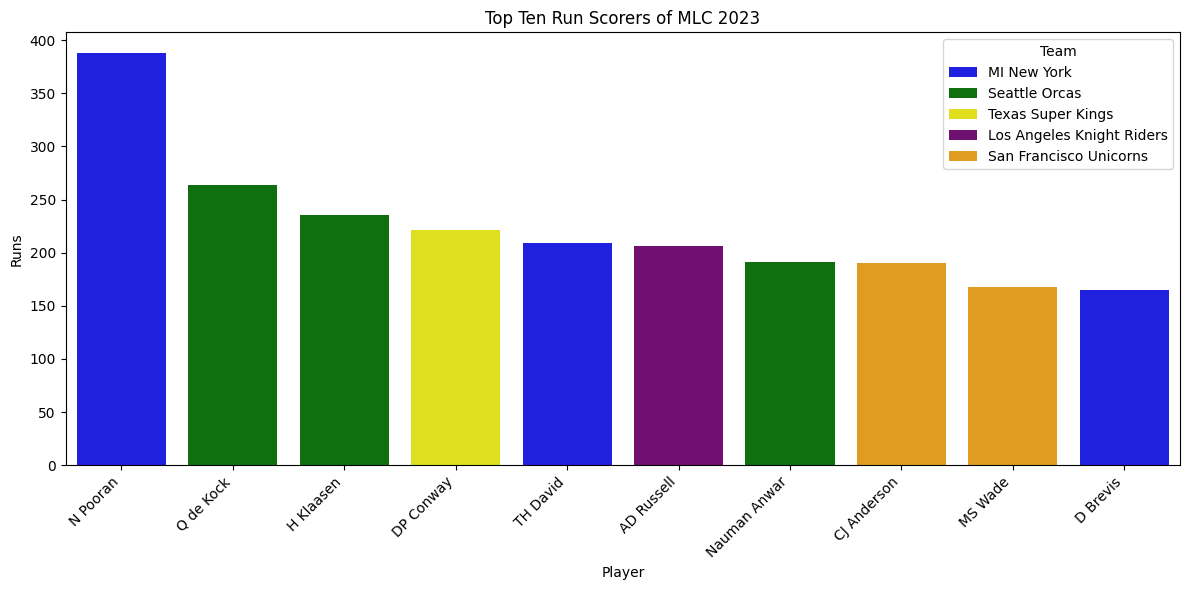

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with Player, Runs, and Team columns
top_ten_scorers_df = pd.DataFrame(top_ten_scorers, columns=['Player', 'Runs'])
top_ten_scorers_df['Team'] = top_ten_scorers_df['Player'].map(team_mapping)

# Define a color palette for the teams
team_colors = {
    'MI New York': 'blue',
    'Seattle Orcas': 'green',
    'Texas Super Kings': 'yellow',
    'San Francisco Unicorns': 'orange',
    'Los Angeles Knight Riders': 'purple',
    'Washington Freedom': 'red'
}

# Create the bar plot with hue='Team'
plt.figure(figsize=(12, 6))
sns.barplot(x='Player', y='Runs', hue='Team', data=top_ten_scorers_df, palette=team_colors)
plt.title('Top Ten Run Scorers of MLC 2023')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Notice that Washington Freedom don't have a single player in this list..

Now, calculating the highest run-scorers against spin specifically..

In [25]:
# Load necessary data
people_df = pd.read_csv('people.csv')
comprehensive_df = pd.read_csv('comprehensive.csv')
all_files = glob.glob(os.path.join(folder_path, "*.json"))

# Create a dictionary to map player identifiers to bowling types
player_bowling_type = dict(zip(comprehensive_df['identifier'], comprehensive_df['Bowling Type']))

# Create a dictionary to store runs against spin for each player
runs_against_spin = {}

# Process JSON files to calculate runs against spin
for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                bowler_name = delivery.get('bowler')
                runs_scored = delivery.get('runs', {}).get('batter', 0)

                # Get identifiers for batter and bowler
                batter_identifier = registry.get(batter_name)
                bowler_identifier = registry.get(bowler_name)

                # Check if bowler is a spin bowler AND batter and bowler are in our data
                if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin' and batter_identifier in player_bowling_type:
                    runs_against_spin[batter_name] = runs_against_spin.get(batter_name, 0) + runs_scored

# Find the highest run scorer against spin
sorted_players_against_spin = sorted(runs_against_spin.items(), key=lambda item: item[1], reverse=True)

# Get the top ten run scorers against spin
top_ten_against_spin = sorted_players_against_spin[:10]


Similar Bar Graph to visualize this data..

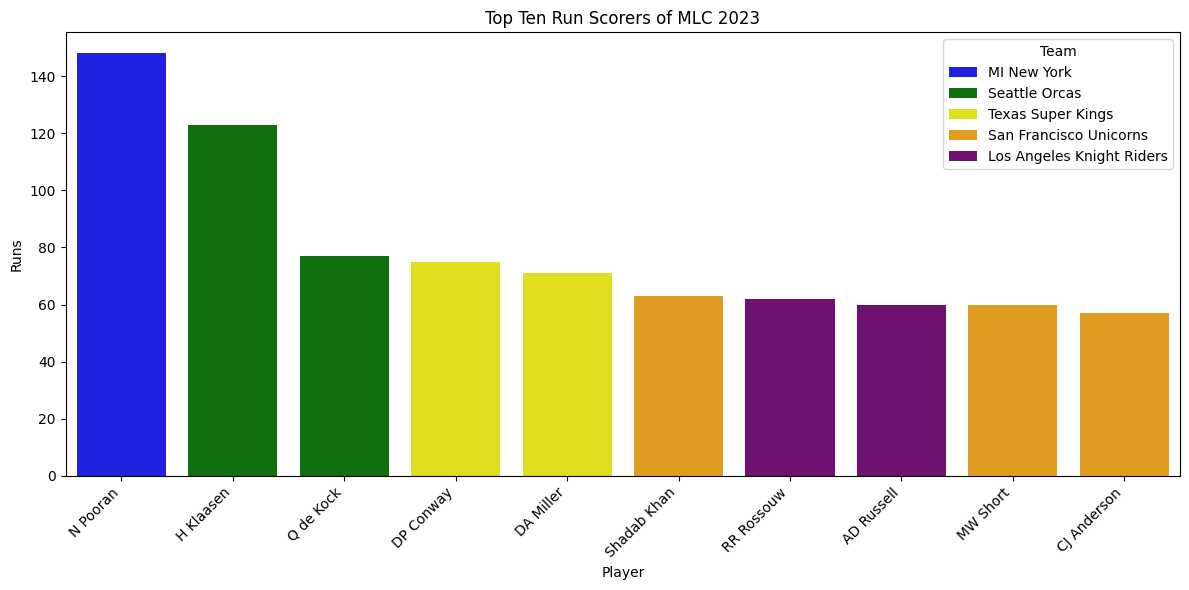

In [31]:
# Create a DataFrame with Player, Runs, and Team columns
top_ten_spin_df = pd.DataFrame(top_ten_against_spin, columns=['Player', 'Runs'])
top_ten_spin_df['Team'] = top_ten_spin_df['Player'].map(team_mapping)

#Team Colors have been assigned in the previous graph itself

# Create the bar plot with hue='Team'
plt.figure(figsize=(12, 6))
sns.barplot(x='Player', y='Runs', hue='Team', data=top_ten_spin_df, palette=team_colors)
plt.title('Top Ten Run Scorers of MLC 2023 against Spin')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now, we are trying to find the batsmen who have been succumbed to spin the most number of times in the 2023 season..

In [63]:
dismissals_against_spin = {}  # Store dismissals against spin for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                # Check if there are any wickets in the delivery
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        kind = wicket.get('kind')

                        if batter_name and kind != 'run out':
                            bowler_name = delivery.get('bowler')

                            # Get identifiers for batter and bowler
                            batter_identifier = registry.get(batter_name)
                            bowler_identifier = registry.get(bowler_name)

                        if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin' and batter_identifier in player_bowling_type:
                          dismissals_against_spin[batter_name] = dismissals_against_spin.get(batter_name, 0) + 1

We have the data now, sorting and printing below..

In [65]:
# Find the players with the most dismissals against spin
sorted_players_by_dismissals = sorted(dismissals_against_spin.items(), key=lambda item: item[1], reverse=True)

# Get the top ten players
top_ten_dismissals_against_spin = sorted_players_by_dismissals[:10]

# Print the results
print("Top Ten Players with Most Dismissals Against Spin in MLC 2023:")
for player, dismissals in top_ten_dismissals_against_spin:
    print(f"{player}: {dismissals} dismissals")

Top Ten Players with Most Dismissals Against Spin in MLC 2023:
DP Conway: 4 dismissals
Milind Kumar: 4 dismissals
Nauman Anwar: 4 dismissals
AJ Finch: 3 dismissals
JS Malhotra: 3 dismissals
MW Short: 3 dismissals
AGS Gous: 3 dismissals
MD Patel: 3 dismissals
Shayan Jahangir: 3 dismissals
GSNFG Jayasuriya: 3 dismissals


Although Conway is one of the more profilic run-scorers against spin (as we saw in our previous graph), he has been dismissed 4 times, high risk high reward!!

Now we look towards finding the spinners who have managed to successfully rattled the stumps for the highest number of times

In [75]:
bowled_dismissal = {}  # Store dismissals against spin for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                # Check if there are any wickets in the delivery
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        kind = wicket.get('kind')

                        if kind == 'bowled': #Filter for bowled dismissals
                            bowler_name = delivery.get('bowler')
                            bowler_identifier = registry.get(bowler_name)

                            if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin':
                              bowled_dismissal[bowler_name] = bowled_dismissal.get(bowler_name, 0) + 1

In [76]:
# We have the data now, sorting and printing below..
sorted_bowled = sorted(bowled_dismissal.items(), key=lambda item: item[1], reverse=True)

# Get the top ten players
top_ten_sorted = sorted_bowled[:10]

# Print the results
print("Top Ten Spinners with Most Bowled Dismissals in MLC 2023:")
for player, dismissals in top_ten_sorted:
    print(f"{player}: {dismissals} dismissals")

Top Ten Spinners with Most Bowled Dismissals in MLC 2023:
Imad Wasim: 4 dismissals
Mohammad Mohsin: 3 dismissals
AJ Hosein: 2 dismissals
SP Narine: 2 dismissals
Harmeet Singh: 2 dismissals
DL Piedt: 1 dismissals
Shadab Khan: 1 dismissals
A Zampa: 1 dismissals
MJ Santner: 1 dismissals
Rashid Khan: 1 dismissals


As we can see, Imad Wasim - who opened the bowling for Orcas - is successful in breaking the stumps most number of times!

Now let's try to do something a bit more complex. Let's start with finding the top wicket scorers of MLC 2023..

In [119]:
wickets_by_bowler = {}

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        bowler_name = delivery.get('bowler')
                        kind = wicket.get('kind')  # Extract kind of dismissal

                        if kind != 'run out':  # Exclude run outs
                            bowler_identifier = registry.get(bowler_name)

                            # Assuming we need to check for the bowler type (optional check for spin)
                            if bowler_identifier:  # Ensure bowler exists in the registry
                                wickets_by_bowler[bowler_name] = wickets_by_bowler.get(bowler_name, 0) + 1

# Sort bowlers by wickets in descending order
sorted_bowlers = sorted(wickets_by_bowler.items(), key=lambda item: item[1], reverse=True)

# Get the top ten bowlers
top_ten_bowlers = sorted_bowlers[:10]

# Print the top ten bowlers
print("Top Ten Bowlers with Highest Number of Wickets in MLC 2023:")
for player, wickets in top_ten_bowlers:
    print(f"{player}: {wickets} wickets")


Top Ten Bowlers with Highest Number of Wickets in MLC 2023:
TA Boult: 22 wickets
CJ Gannon: 11 wickets
AJ Tye: 11 wickets
Imad Wasim: 10 wickets
SN Netravalkar: 10 wickets
A Zampa: 9 wickets
Mohammad Mohsin: 9 wickets
WD Parnell: 9 wickets
M Jansen: 8 wickets
G Coetzee: 8 wickets


Now, let us see how they picked each of their wickets i.e. the mode of dismissal..

In [120]:
# Initialize the dictionary to store dismissal counts for each bowler
top_ten_bowler_dismissals = {}

# List of all possible dismissal types
dismissal_kinds = [
    'bowled', 'caught', 'caught and bowled', 'lbw', 'stumped',
    'run out', 'retired hurt', 'hit wicket', 'obstructing the field',
    'hit the ball twice', 'handled the ball', 'timed out'
]

# Initialize dismissal kinds for each bowler
for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2023':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for bowler_name, _ in top_ten_bowlers:  # Iterate through the top 10 bowlers
        if bowler_name not in top_ten_bowler_dismissals:
            top_ten_bowler_dismissals[bowler_name] = {kind: 0 for kind in dismissal_kinds}  # Initialize all dismissal types for each bowler

        for inning in match_data.get('innings', []):
            for over in inning.get('overs', []):
                for delivery in over.get('deliveries', []):
                    if 'wickets' in delivery:
                        for wicket in delivery['wickets']:
                            current_bowler_name = delivery.get('bowler')
                            if current_bowler_name == bowler_name:
                                kind = wicket.get('kind')
                                if kind and kind in top_ten_bowler_dismissals[bowler_name]:
                                    top_ten_bowler_dismissals[bowler_name][kind] += 1

Code_To_Print_This = """
for bowler, dismissals in top_ten_bowler_dismissals.items():
    print(f"Dismissals for {bowler}:")
    for dismissal_kind, count in dismissals.items():
        print(f"  {dismissal_kind}: {count}")
"""


And let's visualize this on a bar graph!

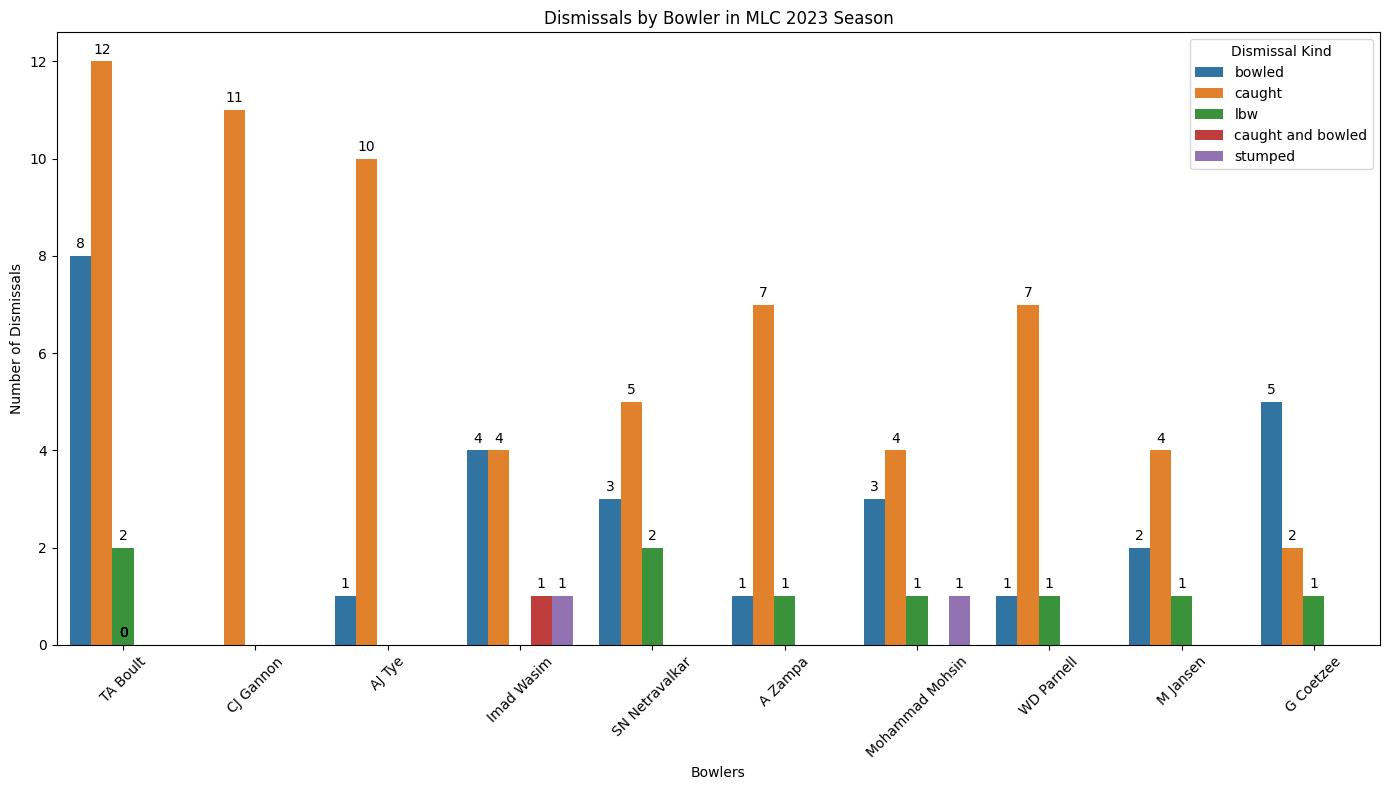

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dismissal kinds as defined earlier which have at least one dismissal
dismissal_kinds = [
    'bowled', 'caught', 'caught and bowled', 'lbw', 'stumped'
]

# Prepare the data for plotting
bowler_names = list(top_ten_bowler_dismissals.keys())
dismissal_counts = []

# Create a list of dismissal counts for each bowler, excluding zero counts
for bowler in bowler_names:
    counts = [top_ten_bowler_dismissals[bowler].get(kind, 0) for kind in dismissal_kinds]
    for i, kind in enumerate(dismissal_kinds):
        if counts[i] > 0:  # Only add dismissal kinds with non-zero counts
            dismissal_counts.append({
                'Bowler': bowler,
                'Dismissal Kind': kind,
                'Count': counts[i]
            })

# Convert to DataFrame
df_dismissals = pd.DataFrame(dismissal_counts)

# Create the seaborn plot
plt.figure(figsize=(14, 8))

# Use seaborn's barplot to create the bar chart
ax = sns.barplot(x='Bowler', y='Count', hue='Dismissal Kind', data=df_dismissals)

# Set labels and title
plt.xlabel('Bowlers')
plt.ylabel('Number of Dismissals')
plt.title('Dismissals by Bowler in MLC 2023 Season')

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Calculate the total dismissals for each bowler and display on top of the bars
for i, bowler in enumerate(bowler_names):
    # Find the positions of the bars for the current bowler
    bars = ax.patches[i * len(dismissal_kinds):(i + 1) * len(dismissal_kinds)]
    total_dismissals = sum([top_ten_bowler_dismissals[bowler].get(kind, 0) for kind in dismissal_kinds])

    # Display total dismissals on top of the last bar in the group
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.0f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()
